## Fetch data from Harvard Dataverse

In [1]:
from scanninglaw.config import config
config['data_dir'] = '/data/asfe2/Projects/gitdata/'

import scanninglaw.asf
scanninglaw.asf.fetch()

Checking existing file "/data/asfe2/Projects/gitdata/cog/cog_dr2_asf_v1.h5" to see if MD5 sum matches ...
File exists. Not overwriting.


# Initialise ASF instance

In [2]:
import scanninglaw.asf as asf
from scanninglaw.source import Source

In [3]:
dr2_asf = asf.asf(version='cogiv_2020')

Loading auxilliary data ...
t = 0.005 s
  auxilliary:   0.005 s


## Estimate Covariance

In [4]:
c = Source(
        '22h54m51.68s',
        '-51d11m44.19s',
        photometry={'gaia_g':16.02},
        frame='icrs')

In [5]:
%precision 4
dr2_asf(c)

array([[ 0.0005,  0.0004, -0.0005,  0.0003,  0.0006],
       [ 0.0004,  0.0029, -0.0023,  0.0016,  0.0013],
       [-0.0005, -0.0023,  0.0057, -0.0026, -0.0034],
       [ 0.0003,  0.0016, -0.0026,  0.0038,  0.0017],
       [ 0.0006,  0.0013, -0.0034,  0.0017,  0.0096]])

## Full on-sky covariance plot

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np, healpy as hp

import astropy.units as units

from scanninglaw.source import Source

nside=128
ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=True, lonlat=True)
g = 18.5*np.ones(ra.shape)

coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g})

In [7]:
matplotlib.rc('font', size=24)

In [8]:
covariance = dr2_asf(coords)

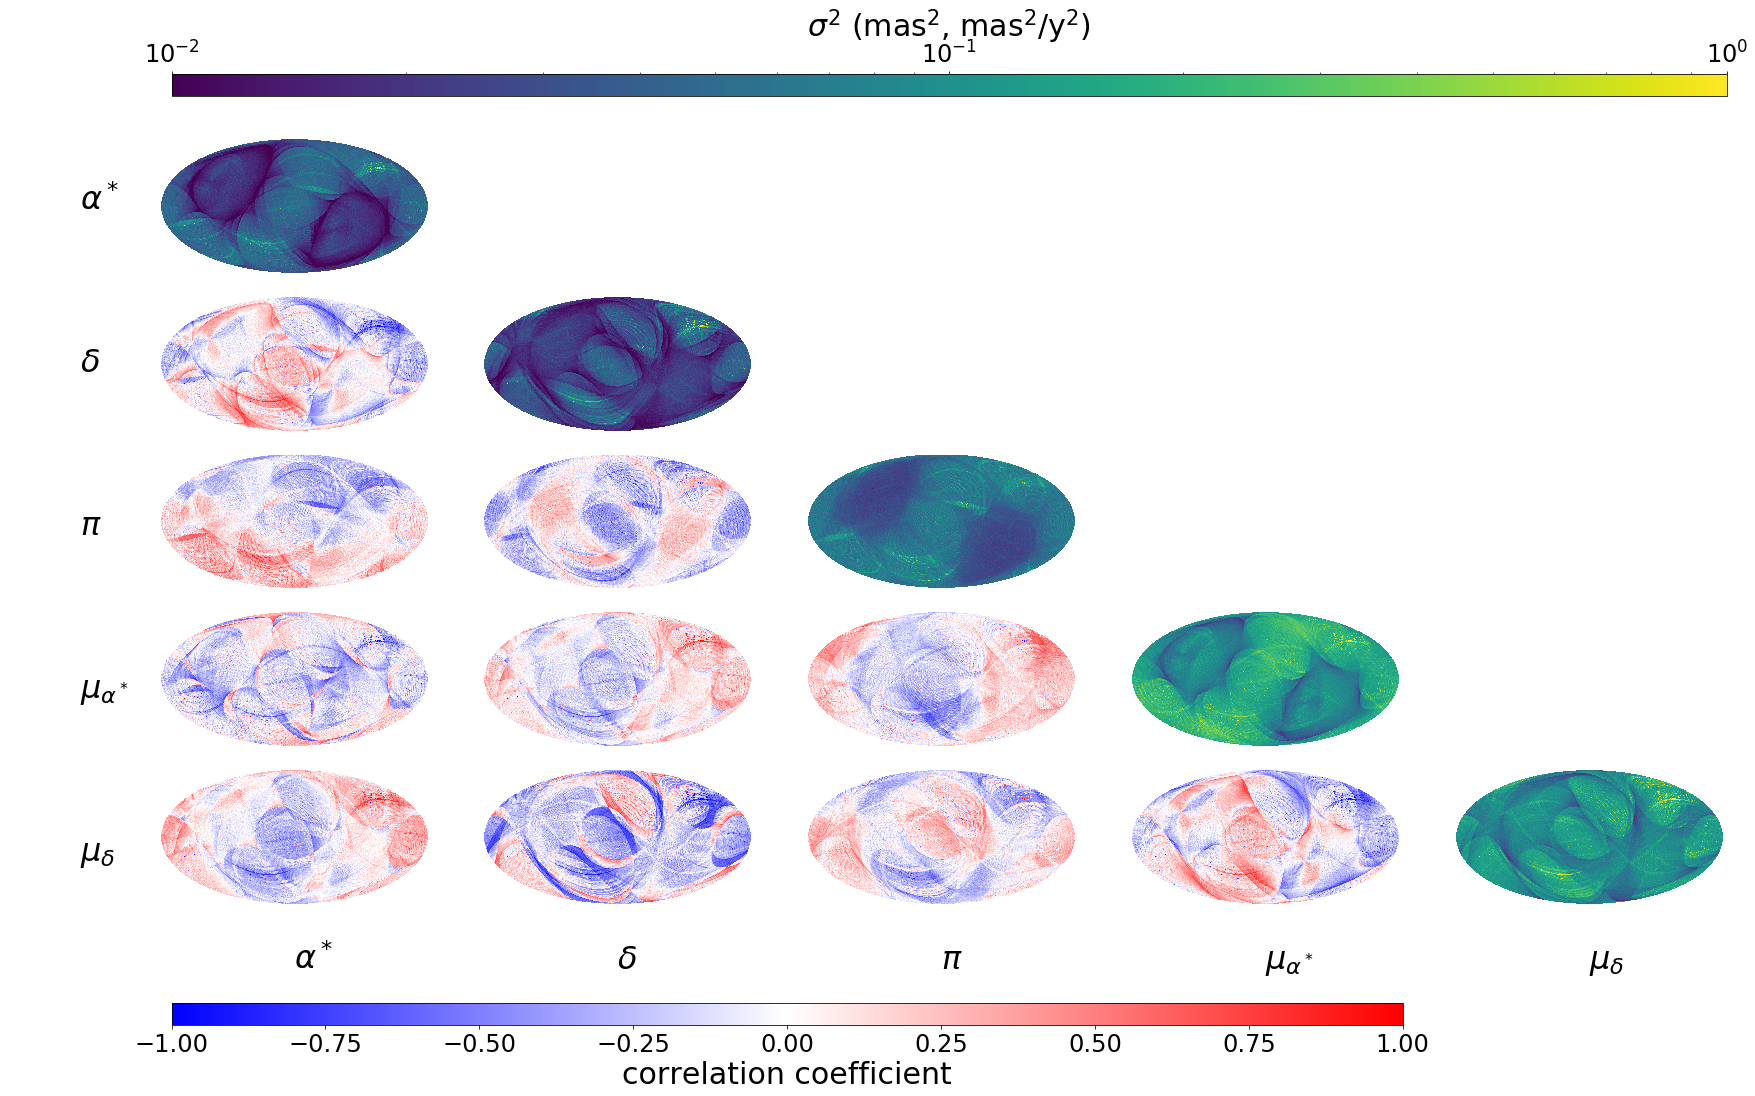

In [9]:
fig, axes = plt.subplots(6,6,figsize=(30,15),  gridspec_kw={'width_ratios': [1,5,5,5,5,5], 
                                                            'height_ratios': [5,5,5,5,5,1]})

for i in range(6): 
    axes[i,0].axis('off')
    axes[5,i].axis('off')

labels = [r'$\alpha^*$', r'$\delta$', r'$\pi$', r'$\mu_{\alpha^*}$', r'$\mu_\delta$']
cov_minmax=(0.01,1)
for i in range(5):
    for j in range(5):
        plt.sca(axes[i,j+1])
        if i==j:hp.mollview(covariance[i,j], min=cov_minmax[0], max=cov_minmax[1],
                             nest=True, hold=True, cmap='viridis', norm='log', coord=['C','G'], 
                             notext=True, cbar=False, title='')
            
        elif j<i: hp.mollview(covariance[i,j]/(np.sqrt(covariance[i,i]*covariance[j,j])), 
                              min=-1, max=1, nest=True, hold=True, cmap='bwr', coord=['C','G'], 
                              notext=True, cbar=False, title='')
        else: plt.axis('off')    
            
for ij in range(5):
    axes[ij,0].annotate(labels[ij], xy=(0.5,0.5), fontsize=32)
    axes[5,ij+1].annotate(labels[ij], xy=(0.5,0.5), fontsize=32)
        
cbar_ax = fig.add_axes([0.18, 0.92, 0.72, 0.02])
norm = matplotlib.colors.LogNorm(vmin=cov_minmax[0], vmax=cov_minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$\sigma^2$ ($\mathrm{mas}^2$, $\mathrm{mas}^2/\mathrm{y}^2$)', fontsize=30)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')    
    
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.18, 0.06, 0.57, 0.02])
norm = matplotlib.colors.Normalize(vmin=-1,vmax=1)
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'correlation coefficient', fontsize=30)